In [ ]:
%%shell
jupyter nbconvert --to html /content/Boston_Airbnb_Open_Data.ipynb

[NbConvertApp] Converting notebook /content/Boston_Airbnb_Open_Data.ipynb to html
[NbConvertApp] Writing 1060102 bytes to /content/Boston_Airbnb_Open_Data.html


In [ ]:
!pip install sentence-transformers

In [ ]:
!pip install lancedb

In [ ]:
!pip install pydantic

In [ ]:
!pip install tiktoken

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.9 MB/s eta 0:00:00


In [ ]:
!pip install openai==0.28

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 936.5 kB/s eta 0:00:00


In [ ]:
from google.colab import drive
import openai
import pandas as pd
import lancedb
import matplotlib.pyplot as plt
import numpy as np
from sentence_transformers import SentenceTransformer
from lancedb.pydantic import vector, LanceModel
import tiktoken

pd.set_option('display.max_colwidth', None)

In [ ]:
api_key = "YOUR-API-KEY-HERE"
openai.api_key = api_key

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
data_dir = '/content/gdrive/MyDrive/listings.csv'
boston_airbnb_df = pd.read_csv(data_dir)

In [ ]:
boston_airbnb_df.shape

(3585, 95)

In [ ]:
pd.unique(boston_airbnb_df['last_scraped'])


array(['2016-09-07'], dtype=object)

In [ ]:
boston_airbnb_df[boston_airbnb_df['neighborhood_overview'].notnull()][['description', 'neighborhood_overview', 'neighbourhood_cleansed']].groupby(['neighbourhood_cleansed']).size()

neighbourhood_cleansed
Allston                    146
Back Bay                   181
Bay Village                 19
Beacon Hill                131
Brighton                   105
Charlestown                 53
Chinatown                   46
Dorchester                 144
Downtown                   108
East Boston                 87
Fenway                     148
Hyde Park                   15
Jamaica Plain              246
Leather District             5
Longwood Medical Area        6
Mattapan                    14
Mission Hill                58
North End                   88
Roslindale                  42
Roxbury                     92
South Boston               114
South Boston Waterfront     41
South End                  225
West End                    32
West Roxbury                24
dtype: int64

In [ ]:
boston_airbnb_df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

## Question 1: Describe the vibe for each neighborhood from the description

We leverage the power of LLM for generating the vibe of each neighborhood from the descriptions. The steps that we will take follow and standard RAG pattern:

  - Generate the embeddings for the descriptions of the neighborhood and sotre it in a vector database
  - For each question about the neighboord`s vibe, retrieve the most relevant context
  - Generate an appropiate prompt and let LLM resolve the question with the provided context

### Generation of the vector database


The next functions allo us to generate a local database from the neighborhood descriptions.

In [ ]:
def generate_embeddings(MODEL_NAME, data):
  """

  Args:
    MODEL_NAME: LLM model used to generate the embeddings
    data: List of string from which to abtain the embeddgins

  Returns:

  """


  model = SentenceTransformer(MODEL_NAME)
  embeddings = model.encode(data)
  return embeddings

In [ ]:
def create_table_to_database(table_name, table_schema, db_instance):
  """

  Args:
    table_name: table name for the table to be created
    table_schema: table schema for the table to be created
    db_instance: db instance on whoch we crate the table
  """
  db_instance.drop_table(table_name, ignore_missing=True)
  table = db_instance.create_table(table_name, schema=table_schema)
  return table

In [ ]:
def get_prompt_neighbourhood_vibe(vibe_question, neighborhood_descriptions, max_tokens=4096):
  """

  Args:
    vibe_question: a formulation for the vibe of the neighborhood
    neighborhhod: neighborhood name
    max_tokens: maximum number of tokens allowed for the propmt.
  """

  propmt = """

  Given the context provided below, generate a description for the vibe of the neighborhood.
  The information about the neighborhoud must be extracted from the context and it is not allowed to include any information that does not appear in the context.

  Context: {}


  question: {}
  Neighborhood description:

  """

  tokenizer = tiktoken.get_encoding('cl100k_base')
  current_number_tokens = len(tokenizer.encode(vibe_question)) + len(tokenizer.encode(propmt))
  l_context = []

  # Construct the string in a format suitable for the prompt template

  for text in neighborhood_descriptions:
    current_number_tokens += len(tokenizer.encode(text))
    if current_number_tokens <= max_tokens:
      l_context.append(text)
    else:
      break

  context = '\n\n###\n\n'.join(l_context)

  return propmt.format(context, vibe_question)


In [ ]:
def generate_answer(prompt_template, max_tokens=2024):
    """

    Args:
      prompt_template: prompt template to be sent via API to OpenAI
      max_tokens: maximum number of tokens allowed for the propmt.

    Returns:

    """
    try:
        # Calling the OpenAI API with a system message and our prompt in the user message content
        # Use openai.ChatCompletion.create for openai < 1.0
        # openai.chat.completions.create for openai > 1.0
        response = openai.ChatCompletion.create(
          model="gpt-3.5-turbo",
          messages=[
          {
            "role": "user",
            "content": prompt_template
          }
          ],
        temperature=1,
        max_tokens=max_tokens,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0
        )
        # The response is a JSON object containing more information than the generated review. We want to return only the message content
        return response.choices[0].message.content
    except Exception as e:
        return f"An error occurred: {e}"

In [ ]:
def generate_neighborhood_vibes(neighboods, neighbood_descriptions, neighborhood_table, max_tokens = 1000):
  """

  Args:
    neighboods: set of neighborhoods
    neighbood_descriptions: list of neighborhood descriptions
    neighborhood_table: neghborhood data base table
    max_tokens: max tokens allowed for the propmt
  """

  responses = []
  for neighborhood in neighboods:
    question = 'Which is the vibe for the {} neighborhood?'
    question = question.format(neighborhood)

    # generate embedding for the question
    question_embedding = generate_embeddings(MODEL_NAME, [question])[0]


    # prompt generation
    filter = "neighborhood == '{}'".format(neighborhood)
    top_k_best = neighborhood_table.search(question_embedding).where(filter).metric('cosine').limit(1000000).to_pandas()
    neighborhood_descriptions = list(top_k_best['description'])

    prompt = get_prompt_neighbourhood_vibe(question, neighborhood_descriptions, max_tokens=max_tokens)


    # Call to OpenAI in order to get the response
    answer = generate_answer(prompt, max_tokens=max_tokens)
    responses.append((neighborhood, answer))
  return responses

In [ ]:
# Creation of the database
db = lancedb.connect('~/.lancedb')

In [ ]:
# Creation of the table
table_name = 'neighborhood_description'

# Creation of the schema for the table
class NeighborhoodOverview(LanceModel):
  vector: vector(384)
  neighborhood:str
  description: str

neighborhood_table = create_table_to_database(table_name, NeighborhoodOverview, db)

In [ ]:
# Create data to populate the database
neighbood_descriptions = list(boston_airbnb_df[boston_airbnb_df['neighborhood_overview'].notnull()]['neighborhood_overview'])
neighboods = list(boston_airbnb_df[boston_airbnb_df['neighborhood_overview'].notnull()]['neighbourhood_cleansed'])


In [ ]:
# Generation of the embeddings
MODEL_NAME = 'paraphrase-MiniLM-L6-v2'
embeddings = generate_embeddings(MODEL_NAME, neighbood_descriptions)

In [ ]:
# Creation of a list in order to poputale the negihborhood table data base
neighborhoodinfo = []
for neighborhood_desc, neighborhhood, embedding in zip(neighbood_descriptions, neighboods, list(embeddings)):
  neighborhoodinfo.append(NeighborhoodOverview(
      vector=embedding,
      neighborhood=neighborhhood,
      description=neighborhood_desc
    )
  )

In [ ]:
# Populate the database table
neighborhood_table.add(neighborhoodinfo)

In [ ]:
### BLOCK COMMENTED TO AVOID UNNECESARY CALL TO OPENAI API, INCURRING IN AN EXTRA COST ###


# Call to OpenAI to generate the vibes from the neighborhood descriptions, using prompt engineering techniques

#neighborhood_vibes = generate_neighborhood_vibes(neighboods, neighbood_descriptions, neighborhood_table)

# Creation of a dataframe to store the results

#t_neighborhoods = []
#t_neighborhood_vibes = []
#for t in neighborhood_vibes:
#  t_neighborhoods.append(t[0])
#  t_neighborhood_vibes.append(t[1])


#neighborhood_vibes_df = pd.DataFrame()
#neighborhood_vibes_df['neighborhood'] = t_neighborhoods
#neighborhood_vibes_df['neighborhood_vibe'] = t_neighborhood_vibes

# Persistence of the results to avoid unnecesary calls to Opean AI API

#neighborhood_vibes_df.to_csv('neighborhood_vibes.csv', index=False)

In [ ]:
data_dir = '/content/gdrive/MyDrive/neighborhood_vibes.csv'
neighborhood_vibes_df = pd.read_csv(data_dir)

In [ ]:
neighborhood_vibes_df

,neighborhood,neighborhood_vibe
0,Downtown,"The vibe of the Downtown neighborhood is lively, vibrant, and convenient. It is a central location with easy access to restaurants, bars, nightlife, public transportation, and various city attractions. The area is bustling with activity, offering plenty of options for entertainment and exploration. With its proximity to popular landmarks and cultural sites, Downtown Boston is a hub of excitement and energy."
1,Bay Village,"The vibe of the Bay Village neighborhood is described as cute, quiet, and quaint, making it a hidden gem and one of the most unique neighborhoods in town. It is known for its local charm, fabulous location, and proximity to wonderful restaurants, cafes, theaters, and parks. The neighborhood is centrally located, offering easy access to public transportation and nearby attractions such as Boston Commons, the Charles River, Copley Square, and the Theatre District. The presence of street gas lamps adds charm to the streets, creating a peaceful and charming atmosphere in the heart of Boston."
2,Beacon Hill,"The vibe of the Beacon Hill neighborhood is one of historical charm, safety, and quaintness. With its rich history, picturesque architecture, and cobblestone streets, Beacon Hill offers a peaceful and serene atmosphere, making you feel like you've traveled back in time to the colonial days. The neighborhood boasts a combination of old-world charm and contemporary amenities, with a variety of local shops, restaurants, and taverns to explore. The proximity to the Boston Common and the Charles River adds to the neighborhood's appeal, providing opportunities for relaxation and learning about American history. Overall, Beacon Hill is a prestigious and desirable neighborhood known for its beauty, rich history, and central location in Boston."
3,South End,"The South End is a trendy, vibrant, and diverse neighborhood known for its historic architecture, charming boutiques, sophisticated eateries, and thriving arts scene. Residents take pride in living here, with owner-operated businesses offering creative offerings. The area is very walkable, with lush trees and flowers lining the streets, creating a European feel. The neighborhood is home to a mix of old and young residents from various backgrounds, making it a culturally rich community. Overall, the South End exudes a lively and welcoming vibe with plenty of local charm and character."
4,Brighton,"The vibe of the Brighton neighborhood is a mix of suburban charm and city convenience. It is a safe and family-friendly area with a diverse selection of cafes, restaurants, and bars to explore. The neighborhood offers easy access to public transportation, making it convenient for residents to travel to different parts of Boston and beyond. With parks, green areas, and proximity to universities like Boston College and Boston University, Brighton is a quiet and scenic residential area with a laid-back atmosphere. Additionally, the neighborhood provides options for dining, shopping, and recreational activities, catering to both locals and visitors."
5,South Boston,"South Boston has a vibrant and lively vibe with a mix of old and new attractions. It offers a true neighborhood feel while being close to downtown and the waterfront, providing easy access to explore the city. The neighborhood boasts a variety of restaurants, bars, coffee shops, and even a beach nearby, making it a desirable location for both locals and visitors. In addition, South Boston is described as having a bustling nightlife, with plenty of options for entertainment, while maintaining a residential feel during the week."
6,Jamaica Plain,"Jamaica Plain is a vibrant, diverse, and eclectic neighborhood with a strong sense of community. It is known for its green spaces, cultural diversity, local restaurants, and artistic influences. The neighborhood offers a mix of urban amenities and a small-town feel, making it a unique and lively place to live or visit."
7,Hyde Par

## Question 2: What are the busiest times of the year to visit Boston? By how much do prices spike?

In [ ]:
data_dir = '/content/gdrive/MyDrive/calendar.csv'
boston_airbnb_calendar_df = pd.read_csv(data_dir)

As we can see, it is desiderable a change data type for the price, available and date columns:

In [ ]:
boston_airbnb_calendar_df.dtypes

listing_id     int64
date          object
available     object
price         object
dtype: object

In [ ]:
# Price column normalization
price_normalized = [x if pd.isna(x) else x[1:].replace(',', '') for x in boston_airbnb_calendar_df['price']]
boston_airbnb_calendar_df['price_normalized'] = price_normalized
boston_airbnb_calendar_df['price_normalized'] = boston_airbnb_calendar_df['price_normalized'].astype(float)


# Available column normalization
available_normalized = [True if x == 't' else False for x in boston_airbnb_calendar_df['available']]
boston_airbnb_calendar_df['available_normalized'] = available_normalized

# date column normalization
boston_airbnb_calendar_df['date_normalized'] = pd.to_datetime(boston_airbnb_calendar_df['date'])

# Creation of a month-year column
month_year = [x[:7] for x in boston_airbnb_calendar_df['date']]
boston_airbnb_calendar_df['month_year'] = month_year
boston_airbnb_calendar_df['month_year'] = pd.to_datetime(boston_airbnb_calendar_df['month_year'], format='%Y-%m')


In [ ]:
boston_airbnb_calendar_df.dtypes

listing_id                       int64
date                            object
available                       object
price                           object
price_normalized               float64
available_normalized              bool
date_normalized         datetime64[ns]
month_year              datetime64[ns]
dtype: object

In [ ]:
boston_airbnb_calendar_df.head()

,listing_id,date,available,price,price_normalized,available_normalized,date_normalized,month_year
0,12147973,2017-09-05,f,NaN,NaN,False,2017-09-05,2017-09-01
1,12147973,2017-09-04,f,NaN,NaN,False,2017-09-04,2017-09-01
2,12147973,2017-09-03,f,NaN,NaN,False,2017-09-03,2017-09-01
3,12147973,2017-09-02,f,NaN,NaN,False,2017-09-02,2017-09-01
4,12147973,2017-09-01,f,NaN,NaN,False,2017-09-01,2017-09-01


In [ ]:
boston_airbnb_calendar_df.columns

Index(['listing_id', 'date', 'available', 'price', 'price_normalized',
       'available_normalized', 'date_normalized', 'month_year'],
      dtype='object')

In [ ]:
boston_airbnb_calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308890 entries, 0 to 1308889
Data columns (total 8 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   listing_id            1308890 non-null  int64         
 1   date                  1308890 non-null  object        
 2   available             1308890 non-null  object        
 3   price                 643037 non-null   object        
 4   price_normalized      643037 non-null   float64       
 5   available_normalized  1308890 non-null  bool          
 6   date_normalized       1308890 non-null  datetime64[ns]
 7   month_year            1308890 non-null  datetime64[ns]
dtypes: bool(1), datetime64[ns](2), float64(1), int64(1), object(3)
memory usage: 71.2+ MB


Let´s take a first glance at the data distribution:

In [ ]:
boston_airbnb_calendar_df.describe()

,listing_id,price_normalized,date_normalized,month_year
count,1.308890e+06,643037.000000,1308890,1308890
mean,8.442118e+06,198.438909,2017-03-07 00:00:00.000000256,2017-02-20 06:42:24.657533696
min,3.353000e+03,11.000000,2016-09-06 00:00:00,2016-09-01 00:00:00
25%,4.679319e+06,85.000000,2016-12-06 00:00:00,2016-12-01 00:00:00
50%,8.578710e+06,150.000000,2017-03-07 00:00:00,2017-03-01 00:00:00
75%,1.279603e+07,255.000000,2017-06-06 00:00:00,2017-06-01 00:00:00
max,1.493346e+07,7163.000000,2017-09-05 00:00:00,2017-09-01 00:00:00
std,4.500149e+06,180.142913,NaN,NaN


In [ ]:
#boston_airbnb_calendar_df['year'] = pd.DatetimeIndex(boston_airbnb_calendar_df['date_normalized']).year
#boston_airbnb_calendar_df['month'] = pd.DatetimeIndex(boston_airbnb_calendar_df['date_normalized']).month

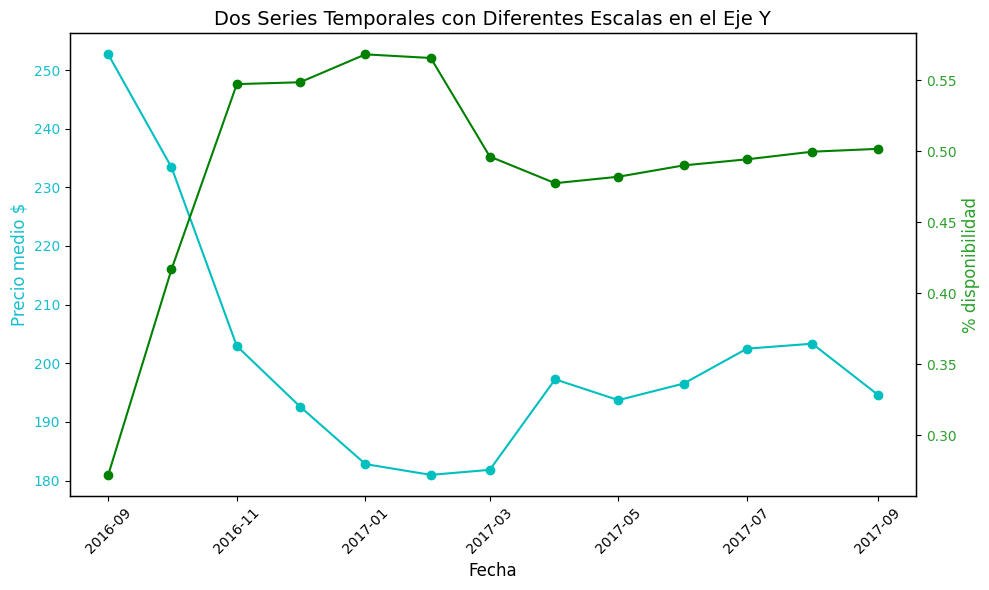

In [ ]:
# Block of calculations for the time series
t_df_boston_my = boston_airbnb_calendar_df.groupby(['month_year']).size().reset_index(name="total_count")
t_df_boston_mya = boston_airbnb_calendar_df.groupby(['month_year', 'available_normalized']).size().reset_index(name="count")
t_df_boston_available = pd.merge(t_df_boston_my, t_df_boston_mya, on='month_year', how='inner')
t_df_boston_available['availability_perc'] = t_df_boston_available['count'] / t_df_boston_available['total_count']
t_df_boston_available = t_df_boston_available[t_df_boston_available['available_normalized'] == True]

t_df_boton_price = boston_airbnb_calendar_df[boston_airbnb_calendar_df['available_normalized'] == True].groupby(['month_year'])['price_normalized'].sum().reset_index(name="total_price")

t_df = pd.merge(t_df_boston_available, t_df_boton_price, on='month_year', how='inner')
t_df['avg_price'] = t_df['total_price'] / t_df['count']
t_df.set_index('month_year', inplace=True)

# Remove data from temporal datasets
t_df_boston_my[0:0]
t_df_boston_mya[0:0]

# Plot eht two series
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotear la primera serie en el primer eje
ax1.plot(t_df.index, t_df['avg_price'], label='Serie 1', color='c', marker='o')

ax1.set_xlabel('Fecha', fontsize=12)
ax1.set_ylabel('Precio medio $', color='tab:cyan', fontsize=12)
ax1.tick_params(axis='y', labelcolor='tab:cyan')
ax1.grid(True)

# Rotar las etiquetas del eje X
plt.xticks(rotation=45)

# Crear el segundo eje que comparte el mismo eje x
ax2 = ax1.twinx()


# Plotear la segunda serie en el segundo eje
ax2.plot(t_df.index, t_df['availability_perc'], label='Serie 2', color='g', marker='o')
ax2.set_ylabel('% disponibilidad', color='tab:green', fontsize=12)
ax2.tick_params(axis='y', labelcolor='tab:green')

# Agregar un título
plt.title('Dos Series Temporales con Diferentes Escalas en el Eje Y', fontsize=14)

# Mejorar la presentación de las leyendas
#fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9), bbox_transform=ax1.transAxes, fontsize=12)

# Agregar un borde negro alrededor del área de trazado
for spine in ax1.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1)

# Remover los bordes superior y derecho
#ax1.spines['top'].set_visible(False)
#ax1.spines['right'].set_visible(False)

#ax2.spines['top'].set_visible(False)
#ax2.spines['left'].set_visible(False)

# Eliminar el fondo con rayas
ax1.set_facecolor('white')
ax2.set_facecolor('white')

# Eliminar la cuadrícula
ax1.grid(False)
ax2.grid(False)

# Ajustar el diseño del gráfico
fig.tight_layout()

# Mostrar el gráfico
plt.show()


The busiest times are from april to september, and the prices spikes in a range from 15 - 70 dollars, depending on the availavitity.

## Question 3: Based on the characteristics of the listing, what groups are there, and which differences in availability and price exist?

In [ ]:
from sklearn import preprocessing
from sklearn.cluster import KMeans

In [ ]:
listing_characteristics = boston_airbnb_df[['property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type']].copy()

Impute missing values:

In [ ]:
listing_characteristics['bathrooms'].fillna((listing_characteristics['bathrooms'].mode()[0]), inplace=True)
listing_characteristics['bedrooms'].fillna((listing_characteristics['bedrooms'].mode()[0]), inplace=True)
listing_characteristics['beds'].fillna((listing_characteristics['beds'].mode()[0]), inplace=True)
listing_characteristics['property_type'].fillna((listing_characteristics['property_type'].mode()[0]), inplace=True)

In [ ]:
listing_characteristics.head()

,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type
0,House,Entire home/apt,4,1.5,2.0,3.0,Real Bed
1,Apartment,Private room,2,1.0,1.0,1.0,Real Bed
2,Apartment,Private room,2,1.0,1.0,1.0,Real Bed
3,House,Private room,4,1.0,1.0,2.0,Real Bed
4,House,Private room,2,1.5,1.0,2.0,Real Bed


In [ ]:
listing_chracteristics_norm = listing_characteristics.copy()

We are going to create a new numerical column to encode the amenities listing. The way to do that is create an embedding representation from the amenities raw text and perfor and average on the embedding. whit this representation, listings with similar amenities will have a very close numeric representation, which is quite reasonable.

In [ ]:
listing_chracteristics_norm = pd.get_dummies(listing_chracteristics_norm, columns=['property_type', 'room_type', 'bed_type'])

In [ ]:
scaler = preprocessing.MinMaxScaler()
listing_chracteristics_norm[['accommodates', 'bathrooms', 'bedrooms', 'beds']] = scaler.fit_transform(listing_chracteristics_norm[['accommodates', 'bathrooms', 'bedrooms', 'beds']])

In [ ]:
listing_chracteristics_norm.head()

,accommodates,bathrooms,bedrooms,beds,property_type_Apartment,property_type_Bed & Breakfast,property_type_Boat,property_type_Camper/RV,property_type_Condominium,property_type_Dorm,...,property_type_Townhouse,property_type_Villa,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed
0,0.200000,0.250000,0.4,0.1875,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,True
1,0.066667,0.166667,0.2,0.0625,True,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
2,0.066667,0.166667,0.2,0.0625,True,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
3,0.200000,0.166667,0.2,0.1250,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
4,0.066667,0.250000,0.2,0.1250,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True


In [ ]:
# Over a number of different cluster counts...

scores = []
centers = list(range(2,10))
    # run k-means clustering on the data and...
for center in centers:
    print("Processing k means with n_clusters: {}".format(center))
    kmeans = KMeans(n_clusters=center, n_init=20)
    model = kmeans.fit(listing_chracteristics_norm)
    # compute the average within-cluster distances.
    score = np.abs(model.score(listing_chracteristics_norm))
    scores.append(score)

Processing k means with n_clusters: 2
Processing k means with n_clusters: 3
Processing k means with n_clusters: 4
Processing k means with n_clusters: 5
Processing k means with n_clusters: 6
Processing k means with n_clusters: 7
Processing k means with n_clusters: 8
Processing k means with n_clusters: 9


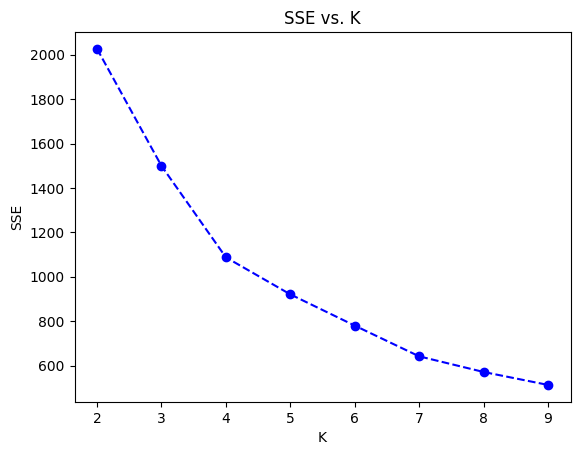

In [ ]:
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [ ]:
# cluster predictions for the general population demographics data.
selected_n_clusters = 4
kmeans = KMeans(n_clusters=selected_n_clusters, n_init=20, random_state=999)
model = kmeans.fit(listing_chracteristics_norm)
kmeans_pred = model.predict(listing_chracteristics_norm)

In [ ]:
set(kmeans_pred)

{0, 1, 2, 3}

In [ ]:
for index in range(selected_n_clusters):
    center = kmeans.cluster_centers_[index].reshape(1, -1)
    original_center = scaler.inverse_transform(kmeans.cluster_centers_[index][[0, 1, 2, 3]].reshape(1, -1))
    center[0][0]  = original_center[0][0]
    center[0][1]  = original_center[0][1]
    center[0][2]  = original_center[0][2]
    center[0][3]  = original_center[0][3]
    for i, column in enumerate(listing_chracteristics_norm.columns):
      print("Column {}, value {}".format(column, center[0][i]))
    print(" ####################################### ")

Column accommodates, value 3.664779161947907
Column bathrooms, value 1.2038505096262733
Column bedrooms, value 1.3346545866364663
Column beds, value 1.786523216308043
Column property_type_Apartment, value 1.0000000000000127
Column property_type_Bed & Breakfast, value -3.677613769070831e-16
Column property_type_Boat, value 9.497611030973019e-17
Column property_type_Camper/RV, value -9.595189226496714e-18
Column property_type_Condominium, value -2.7755575615628914e-17
Column property_type_Dorm, value -1.919037845299343e-17
Column property_type_Entire Floor, value -3.838075690598686e-17
Column property_type_Guesthouse, value -9.595189226496714e-18
Column property_type_House, value 1.4988010832439613e-15
Column property_type_Loft, value 4.597017211338539e-16
Column property_type_Other, value 5.637851296924623e-17
Column property_type_Townhouse, value 6.019490461639521e-16
Column property_type_Villa, value 4.7488055154865094e-17
Column room_type_Entire home/apt, value 1.000000000000011
Colu

In [ ]:
#listing_chracteristics = listing_chracteristics.drop('cluster', axis=1)

In [ ]:
listing_characteristics['cluster'] = kmeans_pred

In [ ]:
listing_characteristics.head()

,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,cluster
0,House,Entire home/apt,4,1.5,2.0,3.0,Real Bed,3
1,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,1
2,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,1
3,House,Private room,4,1.0,1.0,2.0,Real Bed,2
4,House,Private room,2,1.5,1.0,2.0,Real Bed,2


In [ ]:
boston_airbnb_df['cluster'] = kmeans_pred

In [ ]:
cluster_dict = {0: 'Whole apartment', 1: 'Apartement private room', 2: 'Home private room', 3: 'Others entier property'}
cluster_description = [cluster_dict[x] for x in boston_airbnb_df['cluster']]

In [ ]:
boston_airbnb_df['cluster_description'] = cluster_description

In [ ]:
t_calendar_inner_listing_df = boston_airbnb_df.merge(boston_airbnb_calendar_df, left_on='id', right_on='listing_id', how='inner')

In [ ]:
t_calendar_inner_listing_df.shape

(1308890, 105)

In [ ]:
import seaborn as sns

In [ ]:
t_df_boston_my = t_calendar_inner_listing_df.groupby(['cluster_description', 'month_year']).size().reset_index(name="total_count")
t_df_boston_mya = t_calendar_inner_listing_df.groupby(['month_year', 'cluster_description', 'available_normalized']).size().reset_index(name="count")
t_df_boston_available = pd.merge(t_df_boston_my, t_df_boston_mya, on=['month_year', 'cluster_description'], how='inner')
t_df_boston_available['availability_perc'] = t_df_boston_available['count'] / t_df_boston_available['total_count']

In [ ]:
t_df_boston_my = t_calendar_inner_listing_df.groupby(['month_year', 'cluster_description']).size().reset_index(name="total_count")
t_df_boston_mya = t_calendar_inner_listing_df.groupby(['month_year', 'cluster_description', 'available_normalized']).size().reset_index(name="count")
t_df_boston_available = pd.merge(t_df_boston_my, t_df_boston_mya, on=['month_year', 'cluster_description'], how='inner')
t_df_boston_available['availability_perc'] = t_df_boston_available['count'] / t_df_boston_available['total_count']
t_df_boston_available = t_df_boston_available[t_df_boston_available['available_normalized'] == True]

In [ ]:
t_df_boston_available

In [ ]:
t_df_boston_my = t_calendar_inner_listing_df.groupby(['month_year', 'cluster_description']).size().reset_index(name="total_count")
t_df_boston_mya = t_calendar_inner_listing_df.groupby(['month_year', 'cluster_description', 'available_normalized']).size().reset_index(name="count")
t_df_boston_available = pd.merge(t_df_boston_my, t_df_boston_mya, on=['month_year', 'cluster_description'], how='inner')
t_df_boston_available['availability_perc'] = t_df_boston_available['count'] / t_df_boston_available['total_count']
t_df_boston_available = t_df_boston_available[t_df_boston_available['available_normalized'] == True]

t_df_boton_price = t_calendar_inner_listing_df[t_calendar_inner_listing_df['available_normalized'] == True].groupby(['cluster_description', 'month_year'])['price_normalized'].sum().reset_index(name="total_price")

t_df = pd.merge(t_df_boston_available, t_df_boton_price, on=['month_year', 'cluster_description'], how='inner')
t_df['avg_price'] = t_df['total_price'] / t_df['count']
t_df.set_index('month_year', inplace=True)

In [ ]:
t_df

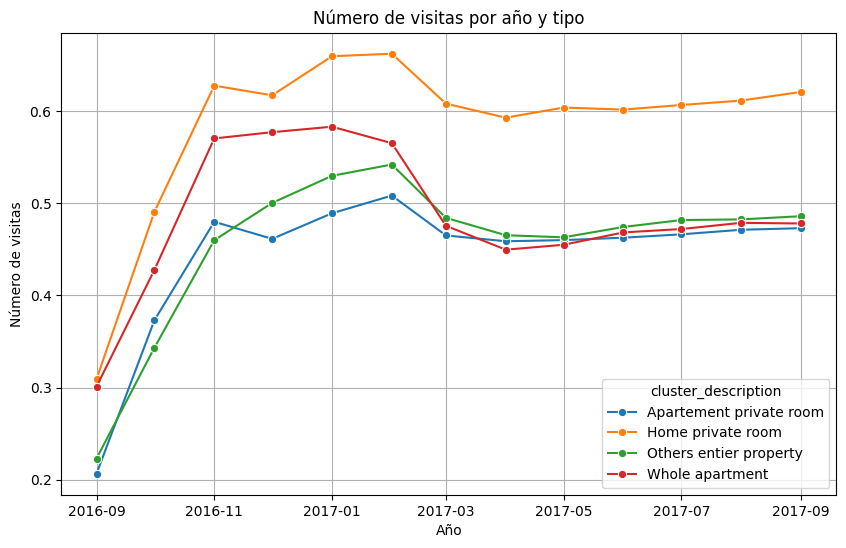

In [ ]:
 # Crear el gráfico
plt.figure(figsize=(10, 6))
sns.lineplot(data=t_df, x='month_year', y='availability_perc', hue='cluster_description', marker='o')

# Añadir títulos y etiquetas
plt.title('Número de visitas por año y tipo')
plt.xlabel('Año')
plt.ylabel('Número de visitas')
plt.grid(True)

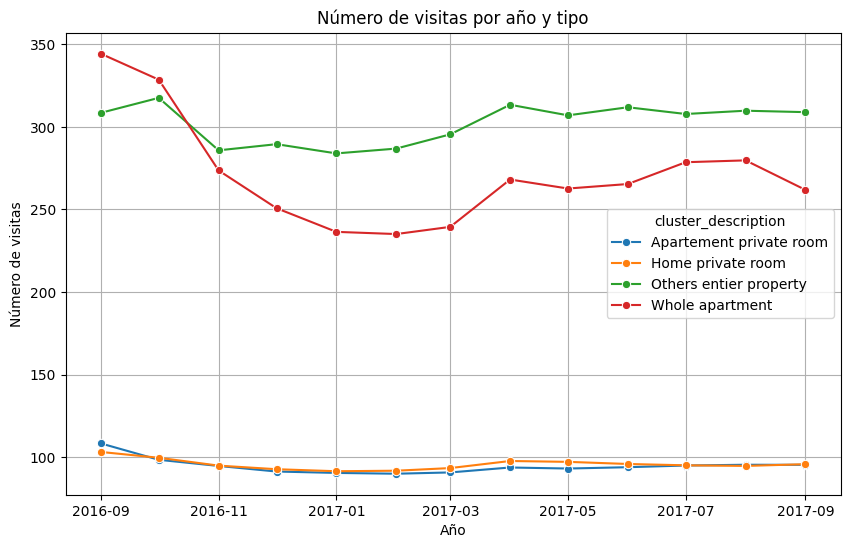

In [ ]:
 # Crear el gráfico
plt.figure(figsize=(10, 6))
sns.lineplot(data=t_df, x='month_year', y='avg_price', hue='cluster_description', marker='o')

# Añadir títulos y etiquetas
plt.title('Número de visitas por año y tipo')
plt.xlabel('Año')
plt.ylabel('Número de visitas')
plt.grid(True)